In [42]:
import pickle as pkl
import pandas as pd
import numpy as np
import re
import preprocessor as p
import pycld2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
custom_stopwords = {
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was","were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between","into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off","over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both","each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very","s", "t", "can", "will", "just", "don", "should", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn", "didn","doesn", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan", "shouldn", "wasn", "weren", "won", "wouldn"
}

In [3]:
def clean_text(text):

    # This effectively removes all special characters
    text = p.clean(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    words = text.split()

    # remove leading and trailing white spaces with strip()
    # remove custom stopwords from text
    words = [word.strip() for word in words if word.strip() not in custom_stopwords]
    text = ' '.join(words)

    # Replace multiple consecutive white spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

In [44]:
def preprocess_data(df):

    # Check for missing values
    missing_values = df.isna().sum()
    print(f'Missing Values:\n{missing_values}\n')

    # Find all tweets that are less than 3 words and remove them
    df['tweet_length'] = [len(text.split()) for text in df.tweet_text]
    df = df.loc[df['tweet_length'] >= 3]
    df.drop('tweet_length', axis=1, inplace=True)

    # Clean the text by removing special characters and converting all text to lower case
    df['tweet_text'] = df['tweet_text'].apply(clean_text)

    return df

In [29]:
def sample(df):

    df = df.loc[df['tweet_text'].apply(lambda x: safe_detect(x) == 'en')]
    
    # Data balancing 
    # Sample 5,916 observation for each category if stop words are removed
    sample_religion = df.loc[df['cyberbullying_type']=='religion'].sample\
        (n=5916, random_state=42)

    sample_age = df.loc[df['cyberbullying_type']=='age'].sample\
        (n=5916, random_state=42)

    sample_other_cyberbullying = df.loc[df['cyberbullying_type']=='other_cyberbullying'].sample\
        (n=5916, random_state=42)

    sample_ethnicity = df.loc[df['cyberbullying_type']=='ethnicity'].sample\
        (n=5916, random_state=42)

    sample_gender = df.loc[df['cyberbullying_type']=='gender'].sample\
        (n=5916, random_state=42)
    
    # Take all not_cyberbullying observations
    not_cyberbullying = df.loc[df['cyberbullying_type']=='not_cyberbullying']
    
    samples_df = pd.concat([sample_religion,sample_age,
                            sample_other_cyberbullying,sample_ethnicity,sample_gender,not_cyberbullying])

    return samples_df


In [6]:
def load_pkl_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

In [7]:
def safe_detect(text):
    try:
        return pycld2.detect(text)[2][0][1]
    except Exception:
        return 'unknown'

In [8]:
def parameter_optimization(X_train, y_train):
    param_dist = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly']}
    random_search = RandomizedSearchCV(svm.SVC(), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
    random_search.fit(X_train, y_train)
    return random_search.best_params_

In [40]:
def confusion_matrix(y_test, y_pred, labels):

    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()


Check raw cyberbullying tweet data:                                           tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64

Check cleaned cyberbullying tweet data:                                           tweet_text cyberbullying_type
0                            words food crapilicious  not_cyberbullying
1                                              white  not_cyberbullying
2                   classy whore red velvet cupcakes  not_cyberbullying
3  meh thanks heads concerned another angry dude ...  not_cyberbullying
4  isis account pretending kurdish account like i... 

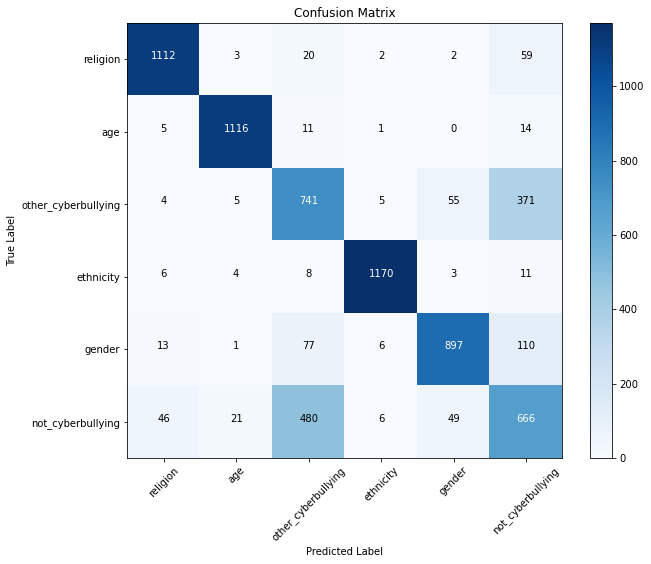

In [45]:
def main():

    df = pd.read_csv("cyberbullying_tweets.csv")
    # Check raw cyberbullying tweet data
    print(f'Check raw cyberbullying tweet data: {df.head(5)}\n')

    df = preprocess_data(df)
    # Check cleaned cyberbullying tweet data
    print(f'Check cleaned cyberbullying tweet data: {df.head(5)}\n')
    
    # Balance data categories
    df = sample(df)
    
    # Check Unique y values
    y_values = df['cyberbullying_type'].value_counts()
    
    for category, count in y_values.items():
        print(f'Y value: {category}, Count: {count}')
    
    print('\n')
    # X is the features (the input data)
    X = df['tweet_text']

    # y is the targets (output or label)
    y = df['cyberbullying_type']

    # Create features based frequency of individual words in a given
    # observation
    vectorized_features = CountVectorizer()

    X = vectorized_features.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, test_size=0.2,
                                                        random_state=42)

    #Perform parameter optimization (Can only be done with powerful hardware)
    #best_parameters = parameter_optimization(X_train, y_train)
    #print(f'Best parameters: {best_parameters}')
    #SVM = svm.SVC(**best_parameters)
    
    # 80.3% best with radial kernel
    SVM = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

    SVM.fit(X_train, y_train)
    y_pred = SVM.predict(X_test)

    print("Training Complete")
    print(f'Accuracy: ', metrics.accuracy_score(y_test, y_pred))

    # Print confusion matrix
    confusion_matrix(y_test, y_pred, labels=df['cyberbullying_type'].unique())
    
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()